In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
!ls /content/gdrive/'My Drive/Colab Notebooks/nmt'

deu.txt  model.h1.20_aug_20  Nmt_QA.ipynb


In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [3]:
# load doc into memory
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text


In [4]:
# split a loaded document into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("/content/gdrive/My Drive/Colab Notebooks/nmt/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

**Text Preprocessing**

In [6]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        'Wenn jemand Fremdes dir sagt, dass du dich wie ein Muttersprachler anhörst, bedeutet das wahrscheinlich: Er hat etwas an deinem Sprechen bemerkt, dass dich als Nicht-Muttersprachler verraten hat. Mit anderen Worten: Du hörst dich nicht wirklich wie ein Muttersprachler an.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #953936 (CK) & #3807493 

In [7]:
deu_eng=deu_eng[:,0:2]
deu_eng.shape

(221533, 2)

In [8]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        'Wenn jemand Fremdes dir sagt, dass du dich wie ein Muttersprachler anhörst, bedeutet das wahrscheinlich: Er hat etwas an deinem Sprechen bemerkt, dass dich als Nicht-Muttersprachler verraten hat. Mit anderen Worten: Du hörst dich nicht wirklich wie ein Muttersprachler an.'],
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        'Wenn jemand, der nicht weiß, woher man kommt, sagt, man erwecke do

In [9]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [10]:
deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['If someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker In other words you dont really sound like a native speaker',
        'Wenn jemand Fremdes dir sagt dass du dich wie ein Muttersprachler anhörst bedeutet das wahrscheinlich Er hat etwas an deinem Sprechen bemerkt dass dich als NichtMuttersprachler verraten hat Mit anderen Worten Du hörst dich nicht wirklich wie ein Muttersprachler an'],
       ['If someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker In other words you dont really sound like a native speaker',
        'Wenn jemand der nicht weiß woher man kommt sagt man erwecke doch den Eindruck Muttersprachler 

In [11]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['if someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker in other words you dont really sound like a native speaker',
        'wenn jemand fremdes dir sagt dass du dich wie ein muttersprachler anhörst bedeutet das wahrscheinlich er hat etwas an deinem sprechen bemerkt dass dich als nichtmuttersprachler verraten hat mit anderen worten du hörst dich nicht wirklich wie ein muttersprachler an'],
       ['if someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker in other words you dont really sound like a native speaker',
        'wenn jemand der nicht weiß woher man kommt sagt man erwecke doch den eindruck muttersprachler 

**Text to Integer Sequence**

The actual data contains over 150,000 sentence-pairs. However, we will use the first 20,000 sentence pairs only to reduce the training time of the model.

In [13]:
deu_eng = deu_eng[:20000,:]
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['am i annoying you', 'langweile ich euch'],
       ['am i annoying you', 'langweile ich sie'],
       ['am i annoying you', 'nerv ich dich']], dtype='<U537')

In [14]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

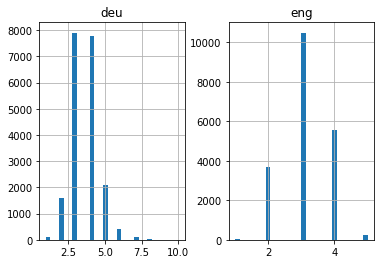

In [15]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30)
plt.show()

In [16]:
print(length_df['eng'].max())
print(length_df['deu'].max())

5
10


maximum length of the German sentences is 15 and that of the English  is 7

**Vectorizing the text data by using Keras's Tokenizer() class.**

In [17]:
#function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [18]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 5
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 3665


In [19]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 10
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 5732


 prepare the sequences and perform sequence padding to a maximum sentence length

In [20]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

**Model Building**

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [22]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(deu_tokenizer, deu_length, train[:, 1])


In [23]:
# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(deu_tokenizer, deu_length, test[:, 1])


In [24]:
#NMT Seq2Seq model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [25]:
model = build_model(eng_vocab_size,deu_vocab_size,eng_length,deu_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Save the best model with lowest validation loss

In [26]:
filename = '/content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.21_aug_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 3.4493
Epoch 00001: val_loss improved from inf to 2.70046, saving model to /content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.21_aug_20
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.21_aug_20/assets
25/25 [==============================] - 14s 556ms/step - loss: 3.4493 - val_loss: 2.7005
Epoch 2/30
25/25 [==============================] - ETA: 0s - loss: 2.3142
Epoch 00002: val_loss improved from 2.70046 to 2.23058, saving model to /content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.21_aug_20
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.21_aug_20/assets
25/25 [==============================] - 13s 5

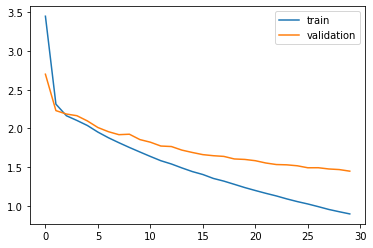

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

**Make Predictions**

In [28]:
testX.shape

(4000, 5)

In [29]:
model = load_model('/content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.21_aug_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [31]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [32]:
# convert predictions into text (German)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], deu_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], deu_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [39]:
pred_df = pd.DataFrame({'english': test[:,0], 'actual' : test[:,1], 'predicted' : preds_text})

In [40]:
pd.set_option('display.max_colwidth', 200)
pred_df.head(15)

,english,actual,predicted
0,i cant stop tom,ich kann tom nicht aufhalten,ich kann tom nicht
1,we heard a noise,wir hörten ein geräusch,wir haben einen
2,this isnt funny,das ist nicht komisch,das ist nicht
3,let go of my arm,lasst meinen arm los,lass sie mit
4,i hate sushi,ich hasse sushi,ich hasse kaffee
5,i dont cuss,ich fluche nicht,ich habe nicht
6,this is simple,das ist einfach,das ist
7,tom is an outlaw,tom ist ein gesetzloser,tom ist ein
8,he is falling,er fällt,er singt
9,ill help you,ich helfe dir,ich werde dich


In [41]:
pred_df.tail(15)

,english,actual,predicted
3985,tom is credible,tom ist glaubwürdig,tom ist fleißig
3986,i hesitated,ich zögerte,ich habe
3987,you need a hobby,du brauchst ein hobby,sie brauchen eine
3988,follow behind me,folgt mir nach,lassen mich mir
3989,tom answered,tom antwortete,tom hat sich
3990,tom will explain,tom wird es erklären,tom wird sich
3991,dont say a word,sag kein wort,wie was ist
3992,tomll succeed,tom wird erfolg haben,tom wird sich
3993,hes my brother,er ist mein bruder,er ist mein bruder
3994,tom is a drummer,tom ist schlagzeuger,tom ist ein


In [42]:
pred_df.sample(15)

,english,actual,predicted
3378,open up the door,öffnen sie die tür,öffne die tür
982,what do we know,was wissen wir,was wissen es
1348,youre not old,sie sind nicht alt,du bist nicht
565,i cant reach it,ich kann ihn nicht erreichen,ich kann es nicht
2313,tom decided,tom hat entschieden,tom hat
695,were not home,wir sind nicht zu hause,wir sind nicht zu
2223,im the bad one,ich bin der böse,ich bin in dem
214,i am lost,ich habe mich verirrt,ich bin mich
467,give me the book,geben sie mir das buch,gib mir mein
3597,is it too big,ist es zu groß,ist es zu


We cn see that translation has taken place using the above Se2seq model from english to German. Although it is not quite good yet because of less computational power available at the time. Building the model using complete 1.5 lac dataset nd running it for more epochs is expected to better the performance. Since, this for now is only for learning the nuances of seq2seq model, I will accept it for now.

**German to English using same architecture**

In [43]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])


In [44]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [45]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [46]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [47]:
filename = '/content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.eng_to_ger_22_aug_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=50, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 4.8954
Epoch 00001: val_loss improved from inf to 3.94031, saving model to /content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.eng_to_ger_22_aug_20
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.eng_to_ger_22_aug_20/assets
25/25 [==============================] - 13s 532ms/step - loss: 4.8954 - val_loss: 3.9403
Epoch 2/50
24/25 [===========================>..] - ETA: 0s - loss: 3.7976
Epoch 00002: val_loss improved from 3.94031 to 3.71403, saving model to /content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.eng_to_ger_22_aug_20
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.eng_to_ger_22_aug_20/assets
25/25 [==============================] - 13s 511ms/step - loss: 3.7925 - val_loss: 3.7140
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 3.6453
Epoch 00003: val_loss improved from 3.71403 to 3.67996, saving model to

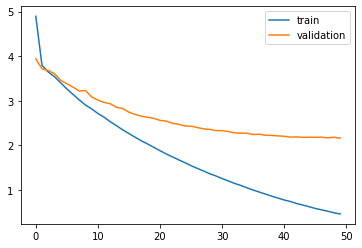

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [49]:
model = load_model('/content/gdrive/My Drive/Colab Notebooks/nmt/model.h1.eng_to_ger_22_aug_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [50]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [51]:
pred1_df = pd.DataFrame({'german': test[:,1], 'actual' : test[:,0], 'predicted' : preds_text})

In [52]:
pred1_df.head(15)

,german,actual,predicted
0,ich kann tom nicht aufhalten,i cant stop tom,i cant see tom
1,wir hörten ein geräusch,we heard a noise,we had a lot
2,das ist nicht komisch,this isnt funny,this isnt fair
3,lasst meinen arm los,let go of my arm,let go of my arm
4,ich hasse sushi,i hate sushi,i hate milk
5,ich fluche nicht,i dont cuss,i dont gossip
6,das ist einfach,this is simple,its simple easy
7,tom ist ein gesetzloser,tom is an outlaw,toms an expert
8,er fällt,he is falling,he is wine
9,ich helfe dir,ill help you,im helping you


In [53]:
pred1_df.tail(15)

,german,actual,predicted
3985,tom ist glaubwürdig,tom is credible,tom is willing
3986,ich zögerte,i hesitated,i nodded
3987,du brauchst ein hobby,you need a hobby,you need a plan
3988,folgt mir nach,follow behind me,follow me
3989,tom antwortete,tom answered,tom was sleeping
3990,tom wird es erklären,tom will explain,tom will try
3991,sag kein wort,dont say a word,tell me the break
3992,tom wird erfolg haben,tomll succeed,tom will starve
3993,er ist mein bruder,hes my brother,hes my brother
3994,tom ist schlagzeuger,tom is a drummer,tom is dishonest


We can observe that german to english translation has occurred. Adding more layers and making our seq2seq model more complex will improve the performance of the model. Training the model on full 150,000 data instead of 20k data will help as well. 

This is not the final model. It is just to learn how a seq2seq model works. Work on this to be continued.